In [1]:
import numpy as np
import matplotlib.pyplot as plt

#load dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("shape before reshaping", x_train.shape)
print("shape of labels", y_train.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
shape before reshaping (60000, 28, 28)
shape of labels (60000,)
(60000, 784)
(10000, 784)


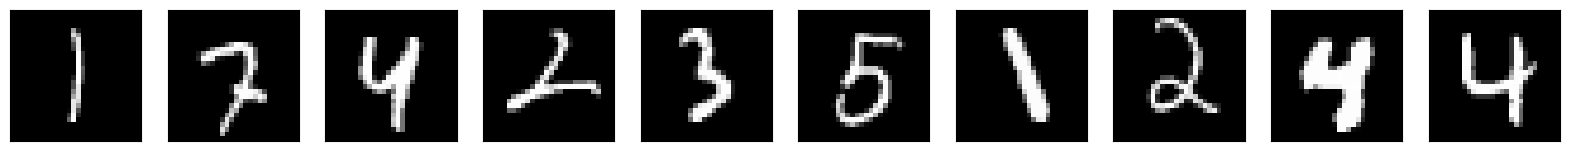

In [4]:
def show_samples(samples):
    n = np.shape(samples)[0]
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(samples[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

show_samples(x_test[40:50])

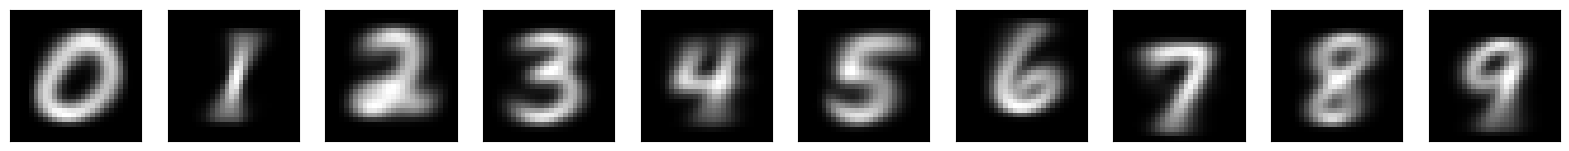

In [5]:
mean_digits = np.zeros((10,784))
for i in range(0,10):
  mean_digits[i]= np.mean(x_train[y_train==i], axis=0)
show_samples(mean_digits)

We shall work with a discrete version of Naive Bayes, so let us discretize the input, e.g. by thresholding.

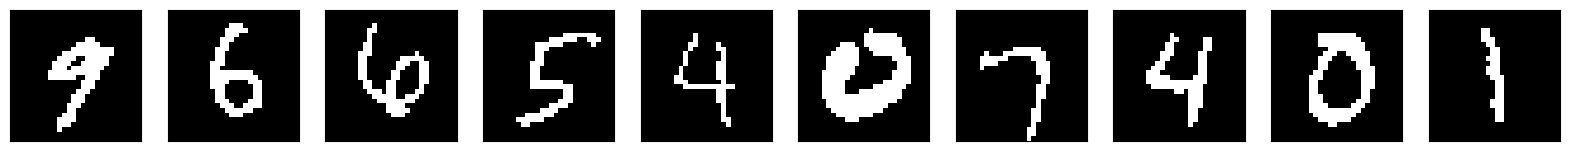

In [6]:
x_train_discr = x_train >.5
x_test_discr = x_test >.5

show_samples(x_test_discr[20:30])

In [7]:
#compute the cardinality of all categories

card = np.zeros((10,1))
for i in range(0,10):
    card[i] = np.sum(y_train == i)

print("card = ", card)

card =  [[5923.]
 [6742.]
 [5958.]
 [6131.]
 [5842.]
 [5421.]
 [5918.]
 [6265.]
 [5851.]
 [5949.]]


We can also plot these frequency as an histogram

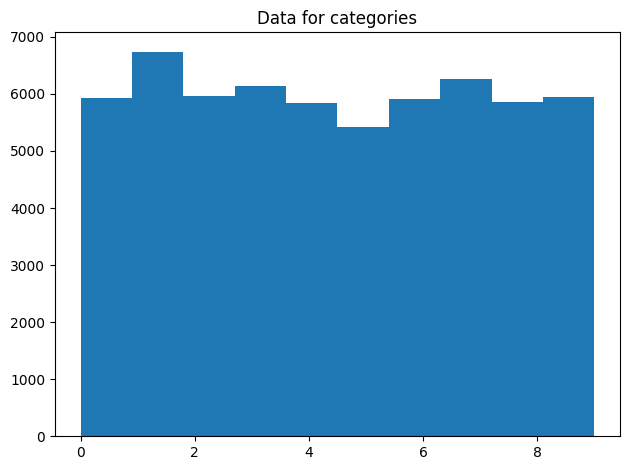

In [8]:
def plot_hist(a,bins=10,title=None):
  plt.figure(tight_layout=True)
  plt.hist(a,bins=bins)
  if title:
    plt.title(title)
  plt.show()

plot_hist(y_train,title="Data for categories")

For each category, and each pixel we compute how frequently it is set to 1 in the training set.

In [9]:
Freq = np.zeros((10,28*28))
for i in range(0,10):
    Freq[i] = np.sum(x_train_discr * np.expand_dims(y_train == i,axis=1), axis=0)

#we add one to ensure it is not 0 (we need to compute logs)
Freq += 1  #we assume Freq < card

Now we want to produce a "segmentatiion" where for each image the background has label "10" and each relevant pixel of a digit is labeled by its own number

0 10
(60000, 784)
0 10


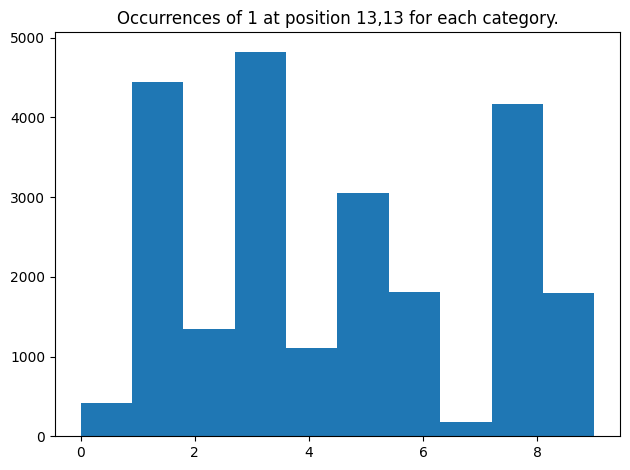

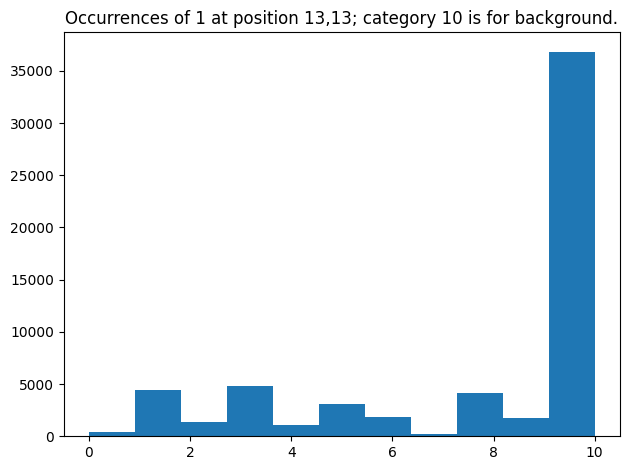

In [15]:
def freq_ij_by_category(i,j,data,labels):
  ldata = (data*(np.expand_dims(y_train+1,axis=1))+10)%11
  #category 10 is for backgound
  print(np.min(ldata),np.max(ldata))
  print(ldata.shape)
  dataij = ldata[:,i*28+j]
  no_background_mask = dataij < 10
  no_background_dataij = dataij[no_background_mask]
  print(np.min(dataij),np.max(dataij))
  plot_hist(no_background_dataij,bins=10,title="Occurrences of 1 at position {},{} for each category.".format(i,j))
  plot_hist(dataij,bins=11,title="Occurrences of 1 at position {},{}; category 10 is for background.".format(i,j))

freq_ij_by_category(13,13,x_train_discr,y_train)

We pass to probabilities, by MLE

In [18]:
#probabilities to be 1
Prob1 = Freq/card  #probabilty to be 1
Prob0 = 1-Prob1    #proability to be 0
print("Prob1, Prob0 shape = ", Prob1.shape, Prob0.shape)

# passing to logs;
logProb1 = np.log(Prob1)
logProb0 = np.log(Prob0)
assert (logProb1 <= 0).all() & (logProb0 <= 0).all()

Prob1, Prob0 shape =  (10, 784) (10, 784)


(10,)
true = 7, predicted = 7

(10,)
true = 2, predicted = 2

(10,)
true = 1, predicted = 1

(10,)
true = 0, predicted = 0

(10,)
true = 4, predicted = 4

(10,)
true = 1, predicted = 1

(10,)
true = 4, predicted = 4

(10,)
true = 9, predicted = 9

(10,)
true = 5, predicted = 4


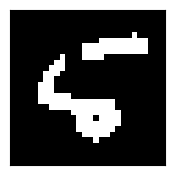

In [ ]:
def classify(img):
    d_img = img > .5
    #loglikelihood
    logp = np.sum(logProb1 * d_img + logProb0*(1-d_img),axis=-1)
    print(logp.shape)
    return(np.argmax(logp))

for i in range(100):
    prediction = classify(x_test[i])
    true = y_test[i]
    print("true = {}, predicted = {}".format(true,prediction))
    if not true == prediction:
        #we show imagae in case of missclassification
        show_samples(np.expand_dims(x_test_discr[i],axis=0))
    x = input()
    if x == 'q':
      break